<a href="https://colab.research.google.com/github/astroChance/MPnet/blob/master/MPnet_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade segyio

     |████████████████████████████████| 92kB 2.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import time
import itertools
import os
import re
import random
from scipy import spatial
import json

In [4]:
### Data filenames

# 3D

Volume3D = "/content/drive/My Drive/MPnet/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  139


Example 2D line data shape:  (202, 3600)


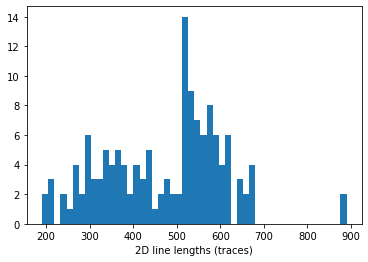


3D data shape:  (501, 501, 1070)


In [ ]:
### Check geometry and line lengths of 2D files

radar_file = random.choice(TwoDFiles)
with segyio.open(radar_file, 'r') as line:
  Line = segyio.tools.collect(line.trace[:])
  print("Example 2D line data shape: ", Line.shape)

Zero_Ax = []

for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r') as line:
    Line = segyio.tools.collect(line.trace[:])
    Zero_Ax.append(Line.shape[0])

plt.hist(Zero_Ax, bins=50)
plt.xlabel("2D line lengths (traces)")
plt.show()




### Print geometry information for 3D cube

with segyio.open(Volume3D, 'r') as segyfile:
  cube = segyio.tools.cube(segyfile)   
  print("\n3D data shape: ", cube.shape)


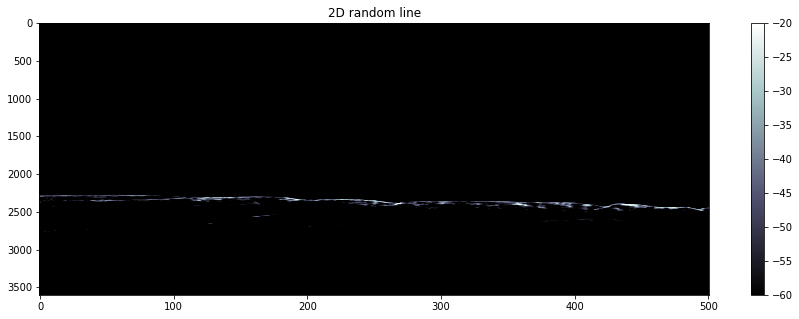

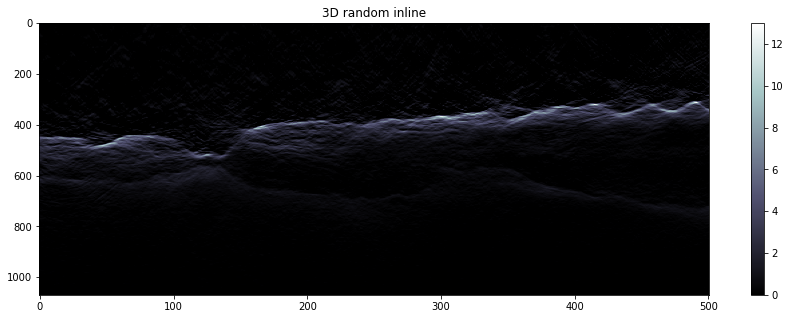

In [ ]:
### Visual QC

# radar_file = TwoDFiles[0]
radar_file = random.choice(TwoDFiles)

with segyio.open(radar_file, 'r') as segyfile:
  display_line = segyio.tools.collect(segyfile.trace[:])

plt.figure(figsize=(15,5))
plt.title("2D random line")
plt.imshow(display_line.T, cmap='bone', vmin = -60, vmax = -20, aspect='auto')
plt.colorbar()

with segyio.open(Volume3D, 'r') as segyfile:
  random_iline_num = random.randint(0, len(segyfile.ilines))
  random_iline = segyfile.iline[segyfile.ilines[random_iline_num]]

plt.figure(figsize=(15,5))
plt.title("3D random inline")
plt.imshow(random_iline.T, cmap='bone', aspect='auto', vmin = 0, vmax = 13)
plt.colorbar()


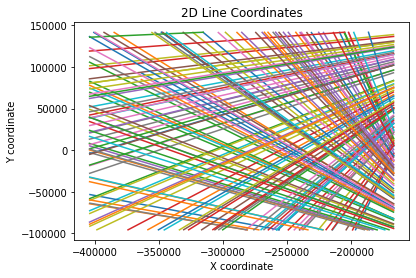

In [ ]:
### Check trace locations from 2D data

line_coords = {}
line_counter = 0
for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    x_vals=[]
    y_vals=[]
    for i in range(len(line.trace)):
      x_vals.append(line.header[i][segyio.TraceField.GroupX])
      y_vals.append(line.header[i][segyio.TraceField.GroupY])
    line_coords[line_counter] = {}
    line_coords[line_counter]['x_vals'] = x_vals
    line_coords[line_counter]['y_vals'] = y_vals
    line_counter += 1


for i in range(len(line_coords)):
  plt.plot(line_coords[i]['x_vals'], line_coords[i]['y_vals'])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("2D Line Coordinates")
plt.show()

In [ ]:
### Data QC
### Amplitude vaies on some 2D lines
### How does this compare to 3D
### Frequency spectra?
### Establish normalization parameters?

In [ ]:
with segyio.open(Volume3D, 'r') as line:
  print(line.header[10])

{TRACE_SEQUENCE_LINE: 11, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 0, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 0, TraceIdentificationCode: 0, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 0, SourceGroupScalar: 0, SourceX: 0, SourceY: 0, GroupX: -404475, GroupY: -90975, CoordinateUnits: 0, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 1070, TRACE_SAMPLE_INTERVAL: 375, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 0, SweepTraceTaperLengthStart: 0, SweepTraceTap

In [ ]:
"""
Design dictionary of:
{2D line number from filename : { 2D trace number : corresponding 3D trace number}

Due to runtime limitations in Colab, write each 2D dict to json file then
concatenate in next cell
"""



# 3D trace coord dictionary, {(Xcoord, Ycoord) : 3D trace number}
# Create array of XY coords for min dist calculation
Trace_coords_3D = {}
coord_3D = np.array([])
counter3D = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(segyfile.trace)):
    Trace_coords_3D[(segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY])] = segyfile.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
    tr_coord = np.array([ segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY] ])
    if counter3D == 0:
      coord_3D = np.append(coord_3D, tr_coord)
    else:
      coord_3D = np.vstack((coord_3D, tr_coord))
    counter3D =+ 1

print("3D trace dictionary complete")


# For each 2D line, build dictionary to map 2D trace number
# to closest 3D trace number

TEMP_DICT = {}

line_counter=1
for radar_line in TwoDFiles[52:]:
  with segyio.open(radar_line, 'r') as line:
    line_num = os.path.basename(radar_line).split(".")[0]

    TEMP_DICT = {}
    TEMP_DICT[line_num] = {}

    trace_counter=1
    for i in range(len(line.trace)):
      trace_2D = line.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
      
      ## Find 3D nearest neighbor for x and y
      ## minimize (dx + dy)
      coord_2D = np.array([ line.header[i][segyio.TraceField.GroupX], line.header[i][segyio.TraceField.GroupY] ])
      
      closest_3Dtrace = coord_3D[spatial.KDTree(coord_3D).query(coord_2D)[1]]
      closest_3Dtrace = tuple(closest_3Dtrace)

      ## Build the dictionary
     
      TEMP_DICT[line_num][trace_2D] = [Trace_coords_3D[closest_3Dtrace]]
      
      print("\rLine number ", line_counter, "\tTrace number ", trace_counter, "\\",len(line.trace), end="", flush=True)
      trace_counter+=1

    temp_Dict = "/content/drive/My Drive/MPnet/GAN data/tempdicts/" + str(line_num) + ".json"
    with open(temp_Dict, 'w') as dict_file:
      json.dump(TEMP_DICT, dict_file)

    line_counter+=1


print("\nIndividual dictionaries complete")


3D trace dictionary complete
Line number  87 	Trace number  489 \ 489Trace mapping dictionary complete, writing file...


In [ ]:
# Check json file count
# Place all individual dicts into master dict

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"

Trace_Matcher = {}

indv_dicts = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/tempdicts"):
    for name in files:
        filename = os.path.join(root, name)
        indv_dicts.append(filename)
print("2D files in directory: ", len(indv_dicts))

for dic in indv_dicts:
  with open(dic, 'r') as temp_dict:
    tempdict = json.load(temp_dict)
    Trace_Matcher.update(tempdict)


with open(Trace_Map_Dict, 'w') as dict_file:
      json.dump(Trace_Matcher, dict_file)


2D files in directory:  138


In [ ]:
## QC dictionary with random sample

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"

with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

print(random.choice(list(TraceDict.items())))

('1043102000', {'1': [250558], '2': [250057], '3': [250058], '4': [249558], '5': [249057], '6': [248557], '7': [248557], '8': [248057], '9': [247557], '10': [247056], '11': [247057], '12': [246557], '13': [246056], '14': [245556], '15': [245557], '16': [245056], '17': [244556], '18': [244056], '19': [244056], '20': [243556], '21': [243056], '22': [243056], '23': [242556], '24': [242056], '25': [241555], '26': [241556], '27': [241055], '28': [240555], '29': [240055], '30': [240055], '31': [239555], '32': [239055], '33': [238554], '34': [238555], '35': [238055], '36': [237554], '37': [237555], '38': [237055], '39': [236554], '40': [236054], '41': [236055], '42': [235554], '43': [235054], '44': [234554], '45': [234554], '46': [234054], '47': [233553], '48': [233053], '49': [233054], '50': [232553], '51': [232053], '52': [231553], '53': [231553], '54': [231053], '55': [230553], '56': [230553], '57': [230053], '58': [229553], '59': [229052], '60': [229053], '61': [228553], '62': [228052], '

2D line:  1971801000
2D trace:  476
3D trace:  197196


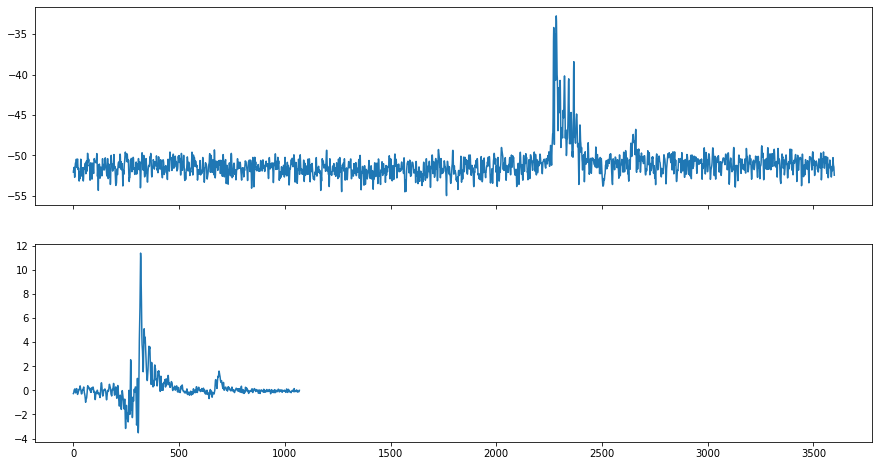

In [6]:
## Print a random 2D trace and it's corresponding 3D trace

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

Rand2D = random.choice(list(TraceDict.items()))
RandTraceMatch = random.choice(list(Rand2D[1].items()))

Rand2DLine = int(Rand2D[0])
Rand2DTrace = int(RandTraceMatch[0])
Rand3DTrace = int(RandTraceMatch[1][0])

print("2D line: ", Rand2DLine)
print("2D trace: ", Rand2DTrace)
print("3D trace: ", Rand3DTrace)

Rand2DFile = "/content/drive/My Drive/MPnet/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_trace_2D = segyfile.trace[Rand2DTrace]

with segyio.open(Volume3D, 'r') as segyfile:
  display_trace_3D = segyfile.trace[Rand3DTrace]

fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))
ax[0].plot(display_trace_2D)
ax[1].plot(display_trace_3D)

(579, 1070)


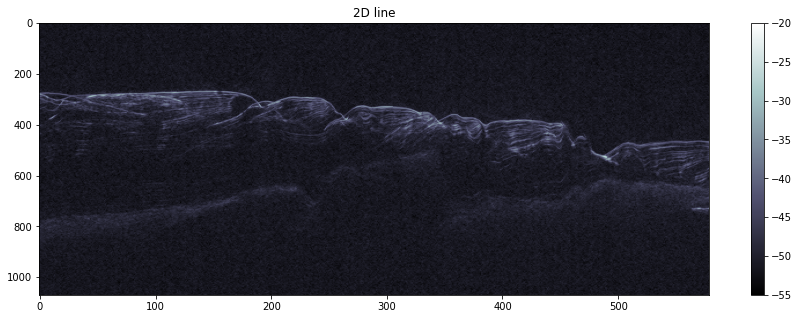

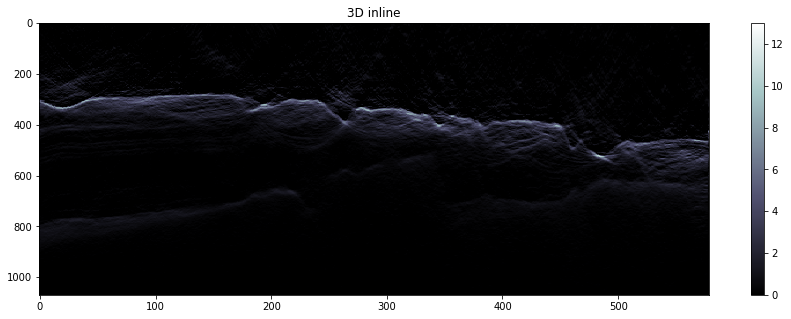

In [36]:
## Plot 2D line and the collected 3D traces

########
# Possible 3D start time: 999.75    end 1401

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

Rand2D = random.choice(list(TraceDict.items()))
Rand2DLine = int(Rand2D[0])
Rand2DFile = "/content/drive/My Drive/MPnet/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_line_2D = segyio.tools.collect(segyfile.trace[:])
  display_line_2D = display_line_2D[:, 1970:3040]
  print(display_line_2D.shape)

display_line_3D = np.array([])
tr_count = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(Rand2D[1])):
    if tr_count == 0:
      display_line_3D = np.append(display_line_3D, segyfile.trace[Rand2D[1][str(i+1)][0]])
    else:
      display_line_3D = np.vstack((display_line_3D, segyfile.trace[Rand2D[1][str(i+1)][0]]))
    tr_count += 1

plt.figure(figsize=(15,5))
plt.title("2D line")
plt.imshow(display_line_2D.T, cmap='bone', vmin = -55, vmax = -20, aspect='auto')
plt.colorbar()

plt.figure(figsize=(15,5))
plt.title("3D inline")
plt.imshow(display_line_3D.T, cmap='bone', aspect='auto', vmin = 0, vmax = 13)
plt.colorbar()


In [24]:
with segyio.open(Rand2DFile, 'r') as segyfile:
  print(len(segyfile.samples))

with segyio.open(Volume3D, 'r') as segyfile:
  print(len(segyfile.samples))

3600
1070
